# Neural style transfer
Following from the [official TensorFlow docs](https://www.tensorflow.org/tutorials/generative/style_transfer), using work by [Gatys et al.](https://arxiv.org/abs/1508.06576).

We implement a style transfer by matching the content statistics of an input image, and style content of another input image, to an output generation. The statistics are extracted using a convolutional NN.

## Setup
Importing the relevant modules and configuring

In [1]:
%matplotlib inline
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,12)
matplotlib.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time, functools

And define a helper function:

In [2]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

## Visualising the input
We will use the Kandisnky example from the tutorial also:

In [3]:
content_path = tf.keras.utils.get_file(
    'YellowLabradorLooking_new.jpg', 
    'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
)
style_path = tf.keras.utils.get_file(
    'kandinsky5.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'
)

Define some more helper functions for image visualisation:

In [4]:
def load_img(path_to_img):
    """ function to load an image and limit its maximum dimension to 512 pixels """
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    """ a simple function to display an image """
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

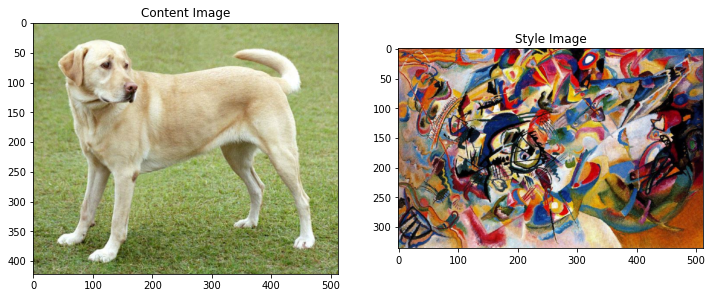

In [5]:
content_image = load_img(content_path)
style_image = load_img(style_path)
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')
plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

### Using a pre-trained model from TensorFlow Hub
We could use a pre-trained model from [TensorFlow Hub](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) to examine what we aim to build. This would require `tensorflow_hub` as an installed package if desired.

## Defining content and style representations
We use the intermediate layers of the models to get content and style representations. The first few layer activations usually represent low-level features like edges and textures; the final layers then represent higher-level features, such as *wheels* or *eyes*. We will base our work off of the [VGG19](https://keras.io/api/applications/#vgg19) network architecture for image classification.

We load a VGG19 and test to ensure the pre-trained model is working as intended:

In [6]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [7]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Labrador_retriever', 0.49317113),
 ('golden_retriever', 0.23665294),
 ('kuvasz', 0.03635755),
 ('Chesapeake_Bay_retriever', 0.024182769),
 ('Greater_Swiss_Mountain_dog', 0.018646104)]

Next we load the VGG19 without the classification head, and list the layer names:

In [8]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


We choose intermediate layers from the network to represent the *style* and *content* of the image:

In [9]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

### Intermediate layers
For image classification to work, the network must develop an 'understanding' of he image in terms of high level features. This is partially why convolutional NN generalize very well; they capture the invariances and defining features of a given class (e.g. cat) that are noise agnostic and relatively invariant.

Somewhere between the input and the output are these sensitivities, the complex feature extractor. By accessing these layers, we can describe the content and style of the image.

## Building the model
The networks in `tf.keras.applications` are designed so we can extract the intermediate layers using the Keras functional API; we do so using the `tf.keras.Model(inputs, outputs)` method. We define a helper function to abstract this

In [10]:
def vgg_layers(layer_names):
    """ create a vgg model that retuns a list of the intermediate output values """
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

And then create the model with

In [11]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

We then examine the statistics of each layer's output:

In [12]:
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8857
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.239
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.135
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2542
  mean:  59.179478



## Calculating style
Content is represented in an image by the values of the intermediate feature maps. Similarly, the *style* of an image can be described by the means and correlations across different feature maps. We calculate a Gram matrix which includes this information
$$
G^l_{cd} = \frac{1}{I J} \sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)
$$
where the above is determined for a particular layer. It is the product of the feature vector with itself at each location, averaging the outer product over all locations.

In TensorFlow, this is implemented for us in `tf.linalg.einsum`:

In [13]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

## Extracting style and content
We will build a model which extracts the style and content tensors. When our model is invoked on an image, it will return the gram matrix (i.e. the *style*) of the `style_layers` and the content of the `content_layers`.

In [14]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        """ float input in [0, 1] """
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        
        style_outputs, content_outputs = (
            outputs[:self.num_style_layers],
            outputs[self.num_style_layers:]
        )
        
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        
        content_dict = {
            content_name: value for content_name, value in zip(self.content_layers, content_outputs)
        }
        
        style_dict = {
            style_name: value for style_name, value in zip(self.style_layers, style_outputs)
        }
        
        return {'content': content_dict, 'style': style_dict}

We instantiate an extractor

In [15]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

Printing these results:

In [16]:
print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0055228444
    max:  28014.557
    mean:  263.79025

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.484
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.44
    mean:  7660.976

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320501.0
    mean:  134288.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.34
    mean:  1487.0381

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8796
    mean:  13.764149


## Gradient descent
With the extractor prepared, we can now implement the style transfer algorithm. We do this by calculating the MSE for the image output relative to each target, then take the weighted sum of those losses.

We set the style and content target values:

In [17]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Then we define a TensorFlow variable to contain the image as to optimize the calculations:

In [18]:
image = tf.Variable(content_image)

We define a helper clipping function:

In [19]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Add the optimizer (the paper uses LBFGS):

In [20]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

We optimize over the weighted combination of the two losses:

In [21]:
style_weight=1e-2
content_weight=1e4

Calculated in full as

In [22]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n(
        [
            tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
            for name in style_outputs.keys()
        ]
    )
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n(
        [
            tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
            for name in content_outputs.keys()
        ]
    )
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

We will use `tf.GradientTape` to [record for auto-diff](https://www.tensorflow.org/api_docs/python/tf/GradientTape) and update the image:

In [23]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        
        grad = tape.gradient(loss, image)
        opt.apply_gradients([(grad, image)])
        image.assign(clip_0_1(image))

We can test it by running a few steps:

In [24]:
train_step(image)
train_step(image)
train_step(image)

And visualise

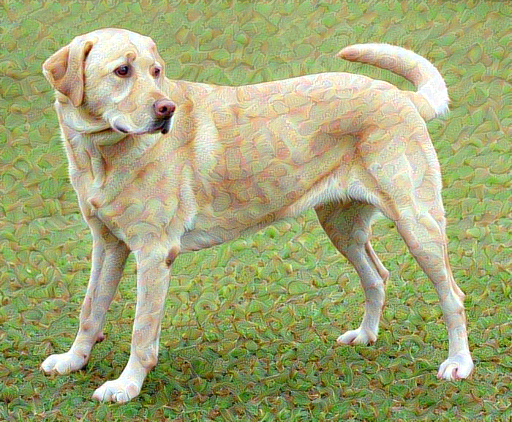

In [25]:
tensor_to_image(image)

As we can see it working, we can perform a longer optimization:

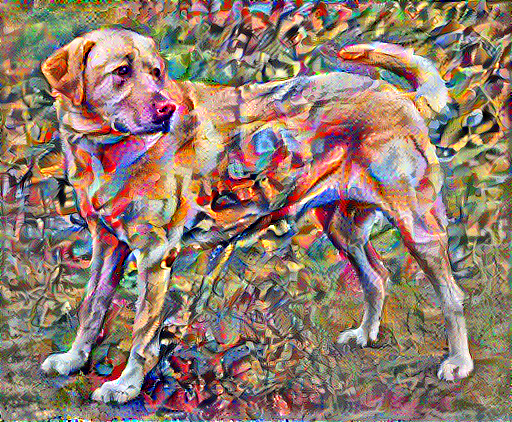

Train step: 1000
Total time: 82.8


In [26]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(f"{m}", end="\r")
    print("")
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

## Total variation loss
The above implementation produces high frequency arifacts, which can be decreased with an explicity regularization term; this is known as *total variation loss*:

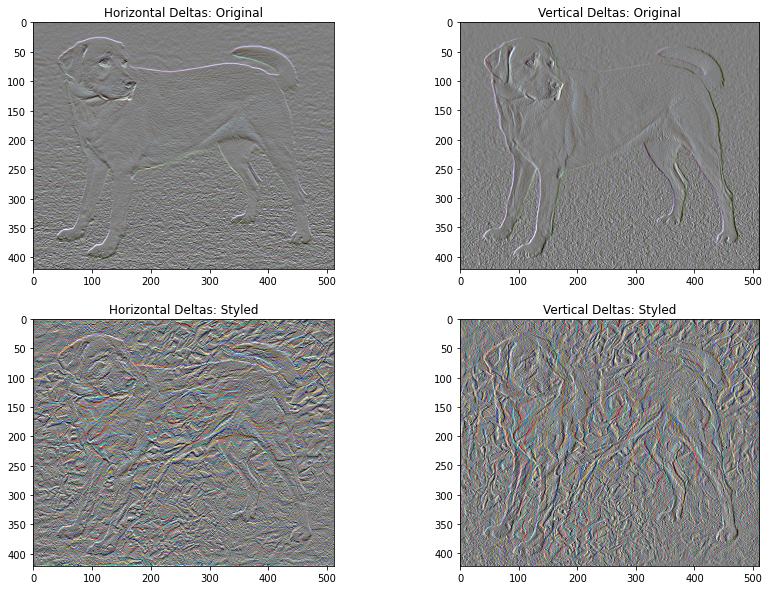

In [27]:
def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]
    return x_var, y_var

x_deltas, y_deltas = high_pass_x_y(content_image)
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas + 0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")


x_deltas, y_deltas = high_pass_x_y(image)
plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

As an aside, this high frequency analysis is a basic edge-detector. Similar output is obtained from the [Sobel edge detector](https://en.wikipedia.org/wiki/Sobel_operator):

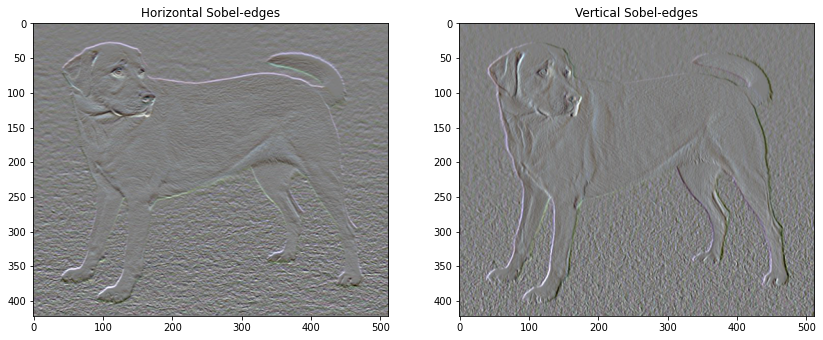

In [28]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

The regularization loss is the sum of the squares. By hand, this could look like:

In [29]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

total_variation_loss(image).numpy()

149398.38

However TensorFlow includes a standard implementation:

In [30]:
tf.image.total_variation(image).numpy()

array([149398.38], dtype=float32)

## Re-run the optimization
Choice of weight for `total_variation_loss`:

In [31]:
total_variation_weight=30

And include this weighted loss in the training:

In [32]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

Which can now be re-run:

In [33]:
image = tf.Variable(content_image)

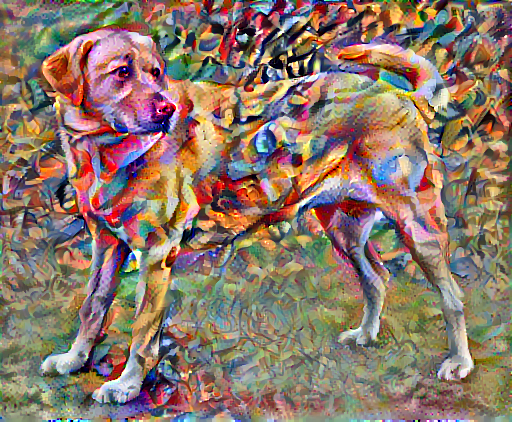

Train step: 1000
Total time: 82.7


In [34]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(f"{m}", end="\r")
    print("")
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))